In [7]:
parquet_file_path = "gs://your-bucket-name/path/to/parquet/file/itineraries.parquet"

## Libraries

In [77]:
# import libraries 
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer,IndexToString, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import collect_set, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import split, slice, size, concat_ws, when
from pyspark.ml.feature import Imputer
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.sql import functions as F
import seaborn as sns 
from pyspark.sql.functions import dayofweek, avg, explode, corr
import numpy as np
import pandas as pd

## Data loading 

In [2]:
# start spark session
spark = SparkSession.builder.appName('Spark-Group1-Flights-EDA').getOrCreate()

In [3]:
# load dataset

# Replace 'your-bucket' and 'path/to/your/file.csv' with your actual GCS bucket and file path
gcs_path = "gs://msca-bdp-student-gcs/Group1/newdata.parquet/"

# Read the CSV file from GCS
df = spark.read.parquet(gcs_path, header=True, inferSchema=True)

# Show the DataFrame
df.show(10)

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|isNonStop|totalFare|seatsRemaining|DaysBeforeFlight|  Layovers|NumStops|        AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|ec53549db1796bc5b...|2022-09-22|2022-11-06|            SFO|    

#### Repartitioning Data

In [4]:
# Repartition data
num = df.rdd.getNumPartitions()
print(num)
df = df.repartition(num)

39


## Summary Stats

#### Numeric Column Stats

In [70]:
# Select numeric columns
numeric_columns = [
    "travelDuration", "elapsedDays", "totalFare", "seatsRemaining", 
    "DaysBeforeFlight", "NumStops", "NumUniqueAirlines", "NumUniqueCabins", "totalTravelDistance"
]

In [6]:
# Define aggregations for numeric columns
aggregations = {
    col: [
        F.min(col).alias(f"{col}_min"),
        F.max(col).alias(f"{col}_max"),
        F.mean(col).alias(f"{col}_mean"),
        F.stddev(col).alias(f"{col}_stddev"),
        F.count(col).alias(f"{col}_count")
    ]
    for col in numeric_columns
}

# Flatten the aggregation dictionary
flat_aggregations = [agg for col_aggs in aggregations.values() for agg in col_aggs]

# Perform the aggregation in one pass
numeric_summary = df.agg(*flat_aggregations)

result = numeric_summary.collect()

# Iterate over each row and column to display the results
for row in result:
    for column in numeric_columns:
        # Extracting the statistics for the current column
        min_value = row[f"{column}_min"]
        max_value = row[f"{column}_max"]
        mean_value = row[f"{column}_mean"]
        stddev_value = row[f"{column}_stddev"]
        count_value = row[f"{column}_count"]
        
        print(f"Column: {column}, Min: {min_value}, Max: {max_value}, Mean: {mean_value}, Stddev: {stddev_value}, Count: {count_value}")

24/11/20 21:16:54 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Column: travelDuration, Min: 31, Max: 2656, Mean: 428.32675645806313, Stddev: 225.21100174011943, Count: 82138753
Column: elapsedDays, Min: 0, Max: 2, Mean: 0.14965308762357277, Stddev: 0.35675674817294706, Count: 82138753
Column: totalFare, Min: 19.59, Max: 8260.61, Mean: 340.38684915195637, Stddev: 196.0295099117068, Count: 82138753
Column: seatsRemaining, Min: 0, Max: 10, Mean: 5.976311522528228, Stddev: 2.8805671114637703, Count: 82138753
Column: DaysBeforeFlight, Min: 1, Max: 60, Mean: 26.900667082199313, Stddev: 16.321090447802046, Count: 82138753
Column: NumStops, Min: 0, Max: 4, Mean: 0.8285768716259913, Stddev: 0.5842696067996042, Count: 82138753
Column: NumUniqueAirlines, Min: 1, Max: 3, Mean: 1.111543317439942, Stddev: 0.31579347942879593, Count: 82138753
Column: NumUniqueCabins, Min: 1, Max: 3, Mean: 1.0013208625166248, Stddev: 0.036331392368029375, Count: 82138753
Column: totalTravelDistance, Min: 89, Max: 7252, Mean: 1599.300201903479, Stddev: 825.7566985215046, Count: 82

#### Categorical Column Stats

In [7]:
# Select categorical columns
categorical_columns = ["AircraftType","startingAirport", "destinationAirport", "isRefundable", "isNonStop", "hasFirstClass"]

# Perform aggregations in one pass
aggregations = [
    F.count(c).alias(f"{c}_count") for c in categorical_columns
] + [
    F.countDistinct(c).alias(f"{c}_unique_count") for c in categorical_columns
]

# Compute summary statistics for categorical columns
categorical_summary = df.agg(*aggregations)

categorical_summary.show(truncate=False)

+------------------+---------------------+------------------------+------------------+---------------+-------------------+-------------------------+----------------------------+-------------------------------+-------------------------+----------------------+--------------------------+
|AircraftType_count|startingAirport_count|destinationAirport_count|isRefundable_count|isNonStop_count|hasFirstClass_count|AircraftType_unique_count|startingAirport_unique_count|destinationAirport_unique_count|isRefundable_unique_count|isNonStop_unique_count|hasFirstClass_unique_count|
+------------------+---------------------+------------------------+------------------+---------------+-------------------+-------------------------+----------------------------+-------------------------------+-------------------------+----------------------+--------------------------+
|82138753          |82138753             |82138753                |82138753          |82138753       |82138753           |4                   

#### Array Column Stats

In [8]:
# Define the array columns
array_columns = ["Layovers", "AirlineNames"]

# Perform the aggregation in one pass
aggregations = []

# For each column, add aggregation functions
for col in array_columns:
    size_col = F.size(col)
    aggregations += [
        F.min(size_col).alias(f"{col}_min_size"),
        F.max(size_col).alias(f"{col}_max_size"),
        F.avg(size_col).alias(f"{col}_mean_size")
    ]

# Compute array size statistics in a single pass
array_stats = df.agg(*aggregations)

array_stats.show(truncate=False)

+-----------------+-----------------+------------------+---------------------+---------------------+----------------------+
|Layovers_min_size|Layovers_max_size|Layovers_mean_size|AirlineNames_min_size|AirlineNames_max_size|AirlineNames_mean_size|
+-----------------+-----------------+------------------+---------------------+---------------------+----------------------+
|0                |4                |0.8285768716259913|1                    |5                    |1.8285768716259911    |
+-----------------+-----------------+------------------+---------------------+---------------------+----------------------+



## PCA

#### Preparing the numeric data

In [ ]:
# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
vectorized_df = assembler.transform(df)

# Standardize the features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(vectorized_df)
scaled_df = scaler_model.transform(vectorized_df)

#### Performing PCA

In [ ]:
# Perform PCA
pca = PCA(k=9, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)

# Transform the data to obtain principal components
pca_df = pca_model.transform(scaled_df)

# Show the result with PCA features
pca_df.select("pca_features").show(truncate=False)

24/11/20 21:21:22 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/11/20 21:21:22 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-9.118889141204477,-3.613048914889872,-15.283450761779806,21.783729714103377,-3.9150873714071652,-2.547618580105037,2.526350153757179,2.3338103873888096,-0.5301548403497609]   |
|[-6.138885685051822,-4.541153821233402,-14.960920606889875,21.89726358894108,-3.3348534160186563,-3.7436340772366847,2.9178289262245256,3.4260679847234865,-0.727149508355464]   |
|[-9.314097503802696,-3.954250974547434,-18.1582368359296,19.214515770283786,-4.429913998002283,-2.5

In [ ]:
pca_df.show()

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+--------------------+--------------------+--------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|isNonStop|totalFare|seatsRemaining|DaysBeforeFlight|  Layovers|NumStops|        AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|            features|     scaled_features|        pca_features|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+----------------+----------+--------+--------------------+-----------------+------------+-------

#### Inspecting Results

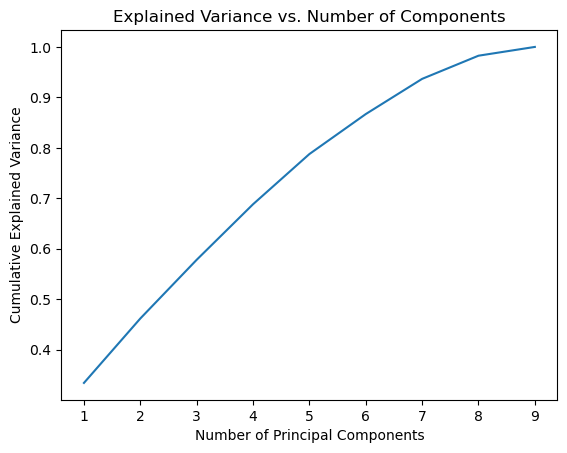

In [ ]:
explained_variance = pca_model.explainedVariance
cumulative_variance = explained_variance.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.show()

###### 8 PC captures 90% of the variance in the data

In [ ]:
# Access principal components or weights for each feature
principal_components = pca_model.pc.toArray()  

feature_names = numeric_columns  

# Print explained variance and features' contributions for each principal component
print("Explained Variance and Features Contribution:")
for i in range(len(explained_variance)):
    print(f"\nPC{i+1} - Explained Variance: {explained_variance[i]}")
    
    # Access the i-th principal component (row in the NumPy array)
    pc_i = principal_components[i]
    
    # Iterate over features (j-th feature weight in i-th PC)
    for j in range(len(feature_names)):
        weight = pc_i[j]  # Weight of the j-th feature in the i-th principal component
        print(f"  Feature: {feature_names[j]}, Weight: {weight}")

Explained Variance and Features Contribution:

PC1 - Explained Variance: 0.3341608128188578
  Feature: travelDuration, Weight: -0.5163865894688805
  Feature: elapsedDays, Weight: 0.07731953317958581
  Feature: totalFare, Weight: 0.16379399380825455
  Feature: seatsRemaining, Weight: 0.04947307458062262
  Feature: DaysBeforeFlight, Weight: -0.09571913182577013
  Feature: NumStops, Weight: 0.046104353977483185
  Feature: NumUniqueAirlines, Weight: 0.30246357537567004
  Feature: NumUniqueCabins, Weight: 0.035063688680962345
  Feature: totalTravelDistance, Weight: -0.770771744515432

PC2 - Explained Variance: 0.12766795443801704
  Feature: travelDuration, Weight: -0.24579362815030287
  Feature: elapsedDays, Weight: 0.07181805386131247
  Feature: totalFare, Weight: 0.5225168202729692
  Feature: seatsRemaining, Weight: 0.4441954721476478
  Feature: DaysBeforeFlight, Weight: 0.30959316185888086
  Feature: NumStops, Weight: -0.5122780939813613
  Feature: NumUniqueAirlines, Weight: -0.293109566

## Exploratory Data Analysis

In [15]:
# Add a new column for the day of the week (1 = Sunday, 7 = Saturday)
df = df.withColumn('dayOfWeek', dayofweek(df['flightDate']))

# Group by the day of the week and calculate average price
df_grouped_by_day = df.groupBy('dayOfWeek').agg(avg('totalFare').alias('avgPrice'))

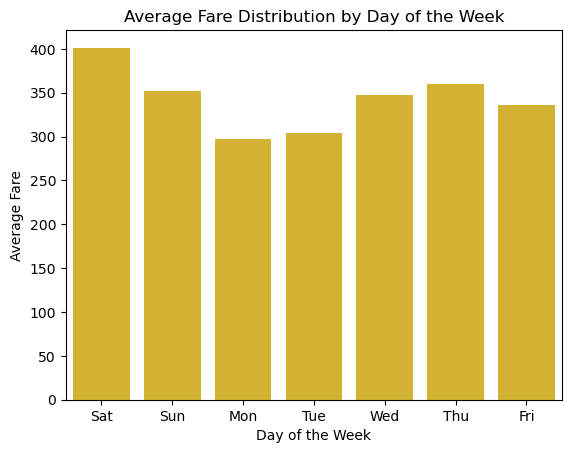

In [16]:
# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped_by_day.toPandas()

sns.barplot(x='dayOfWeek', y='avgPrice', data=df_pandas, color='#EEC218')
plt.title('Average Fare Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare')
plt.xticks(ticks=[0,1, 2, 3, 4, 5, 6], labels=["Sat","Sun", "Mon", "Tue", "Wed", "Thu", "Fri"])
plt.show()

In [11]:
# Explode the AirlineNames array to treat each airline as a separate row
df_exploded_airline = df.withColumn('Airline', explode(df['AirlineNames']))

# Group by Airline and calculate average fare
df_grouped_by_airline = df_exploded_airline.groupBy('Airline').agg(avg('totalFare').alias('avgFare'))

# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped_by_airline.toPandas()

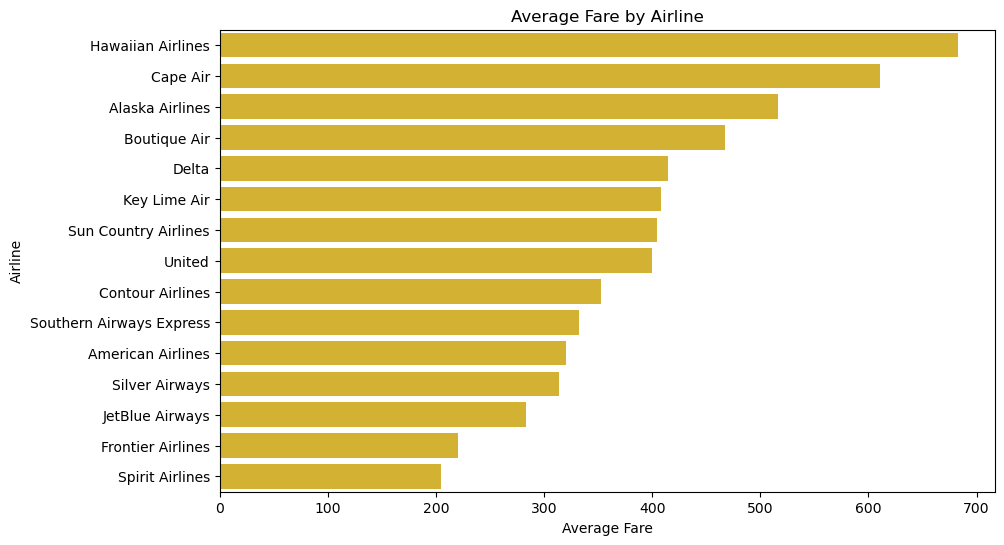

In [12]:
# Sort by average fare for better visualization
df_pandas = df_pandas.sort_values(by='avgFare', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='avgFare', y='Airline', data=df_pandas, color='#EEC218')
plt.title('Average Fare by Airline')
plt.xlabel('Average Fare')
plt.ylabel('Airline')
plt.show()

In [ ]:
# Group by Airline and Non-Stop Status, then calculate the average fare
df_grouped = df_exploded_airline.groupBy('Airline', 'isNonStop').agg(avg('totalFare').alias('avgFare'))

df_grouped.printSchema()

# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped.toPandas()

# Check if the 'isNonStop' column exists and map its values
if 'isNonStop' in df_pandas.columns:
    df_pandas['isNonStop'] = df_pandas['isNonStop'].map({0: 'Non-Stop', 1: 'Not Non-Stop'})
else:
    print("Column 'isNonStop' is not found in the DataFrame")


root
 |-- Airline: string (nullable = true)
 |-- isNonStop: integer (nullable = true)
 |-- avgFare: double (nullable = true)



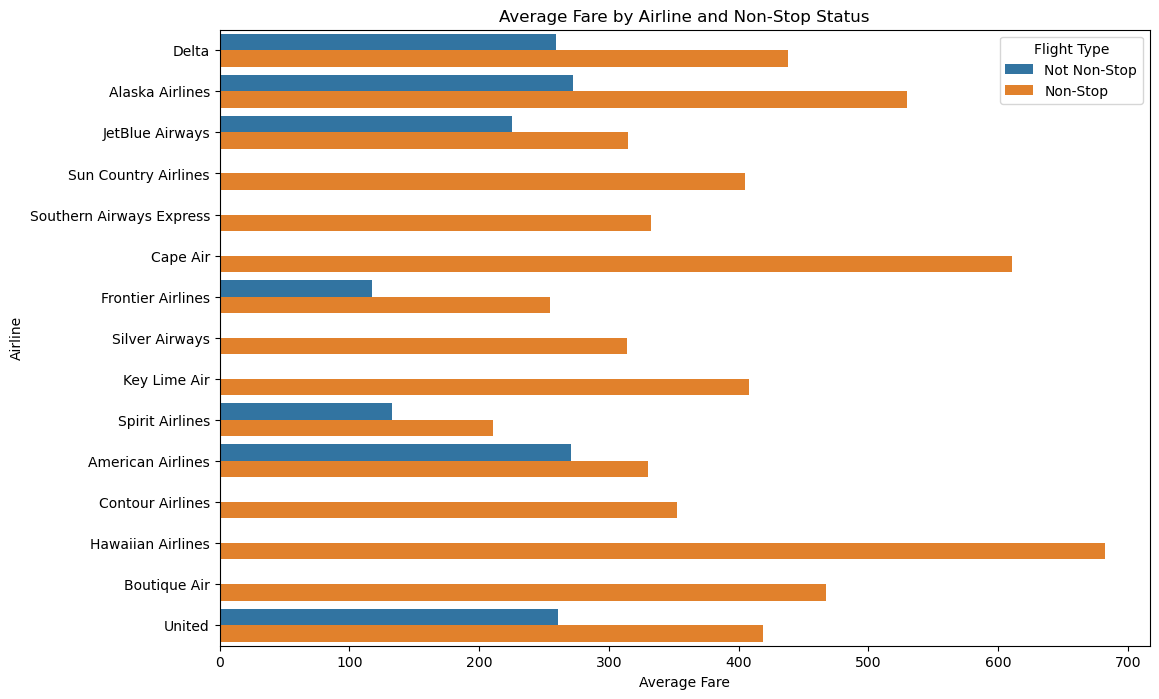

In [ ]:
# Create a bar plot to show average fare by airline and non-stop status
plt.figure(figsize=(12, 8))
sns.barplot(x='avgFare', y='Airline', hue='isNonStop', data=df_pandas, dodge=True)
plt.title('Average Fare by Airline and Non-Stop Status')
plt.xlabel('Average Fare')
plt.ylabel('Airline')
plt.legend(title='Flight Type')
plt.show()

In [ ]:
# Group by seatsRemaining and calculate the average fare
df_grouped = df.groupBy('seatsRemaining').agg(avg('totalFare').alias('avgFare'))

# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped.toPandas()

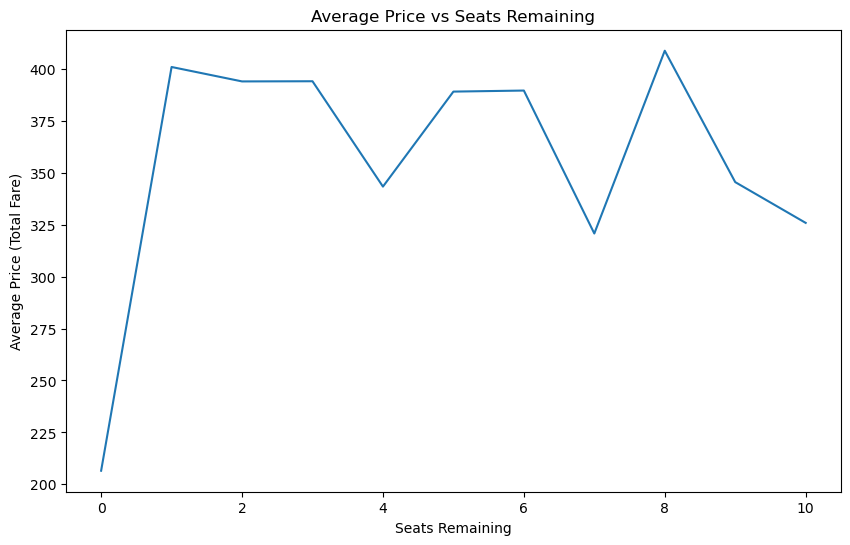

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='seatsRemaining', y='avgFare', data=df_pandas,color='#EEC218')
plt.title('Average Price vs Seats Remaining')
plt.xlabel('Seats Remaining')
plt.ylabel('Average Price (Total Fare)')
plt.show()

In [19]:
# Group by seatsRemaining and calculate the average fare
df_grouped = df.groupBy('NumStops').agg(avg('totalFare').alias('avgFare'))

# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped.toPandas()

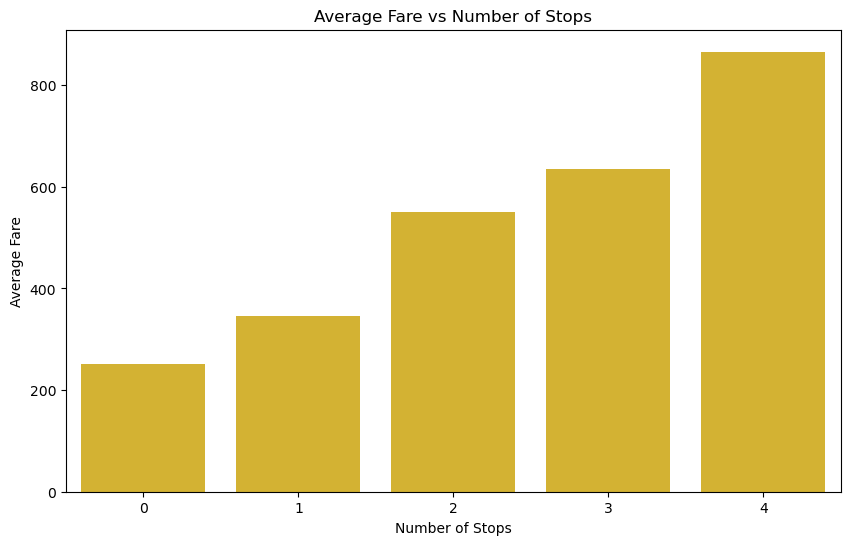

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='NumStops', y='avgFare', data=df_pandas,color='#EEC218')
plt.title('Average Fare vs Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Average Fare')
plt.show()

#### Number of Unique Airlines vs Fare

In [21]:
# Group by seatsRemaining and calculate the average fare
df_grouped = df.groupBy('NumUniqueAirlines').agg(avg('totalFare').alias('avgFare'))

# Collect the result into a Pandas DataFrame for plotting
df_pandas = df_grouped.toPandas()

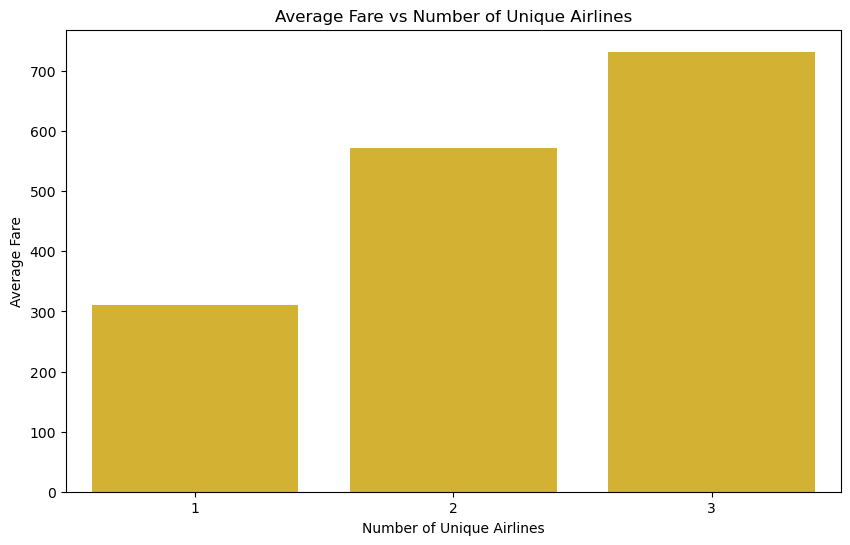

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='NumUniqueAirlines', y='avgFare', data=df_pandas,color='#EEC218')
plt.title('Average Fare vs Number of Unique Airlines')
plt.xlabel('Number of Unique Airlines')
plt.ylabel('Average Fare')
plt.show()

#### Price trend based on days before flight

In [13]:
# Group by DaysBeforeFlight and calculate the average fare
df_days_avg_price = df.groupBy('DaysBeforeFlight').agg(avg('totalFare').alias('avgFare'))

# Convert to Pandas DataFrame for plotting
df_days_pandas = df_days_avg_price.toPandas()

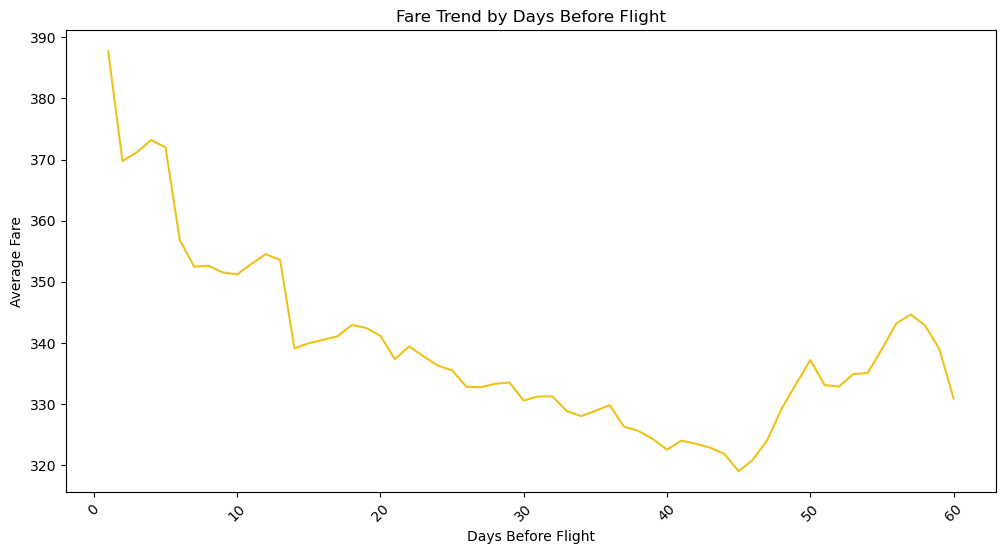

In [15]:
# Create a line plot to show the price trend by days before flight
plt.figure(figsize=(12, 6))
sns.lineplot(x='DaysBeforeFlight', y='avgFare', data=df_days_pandas, color='#EEC218')
plt.title('Fare Trend by Days Before Flight')
plt.xlabel('Days Before Flight')
plt.ylabel('Average Fare')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [27]:
# Display the dates
print(f"Unique flight dates ({len(unique_search_dates_list)} total):")
for date in unique_search_dates_list:
    print(date)

Unique flight dates (217 total):
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
2022-05-01
2022-05-02
2022-05-03
2022-05-04
2022-05-05
2022-05-06
2022-05-07
2022-05-08
2022-05-09
2022-05-10
2022-05-11
2022-05-12
2022-05-13
2022-05-14
2022-05-15
2022-05-16
2022-05-17
2022-05-18
2022-05-19
2022-05-20
2022-05-21
2022-05-22
2022-05-23
2022-05-24
2022-05-25
2022-05-26
2022-05-27
2022-05-28
2022-05-29
2022-05-30
2022-05-31
2022-06-01
2022-06-02
2022-06-03
2022-06-04
2022-06-05
2022-06-06
2022-06-07
2022-06-08
2022-06-09
2022-06-10
2022-06-11
2022-06-12
2022-06-13
2022-06-14
2022-06-15
2022-06-16
2022-06-17
2022-06-18
2022-06-19
2022-06-20
2022-06-21
2022-06-22
2022-06-23
2022-06-24
2022-06-25
2022-06-26
2022-06-27
2022-06-28
2022-06-29
2022-06-30
2022-07-01
2022-07-02
2022-07-03
2022-07-04
2022-07-05
2022-07-06
2022-07-07
2022-07-08
2022-07-09
2022-07-10
2022-07-11
2022-07-12
2022-07-13

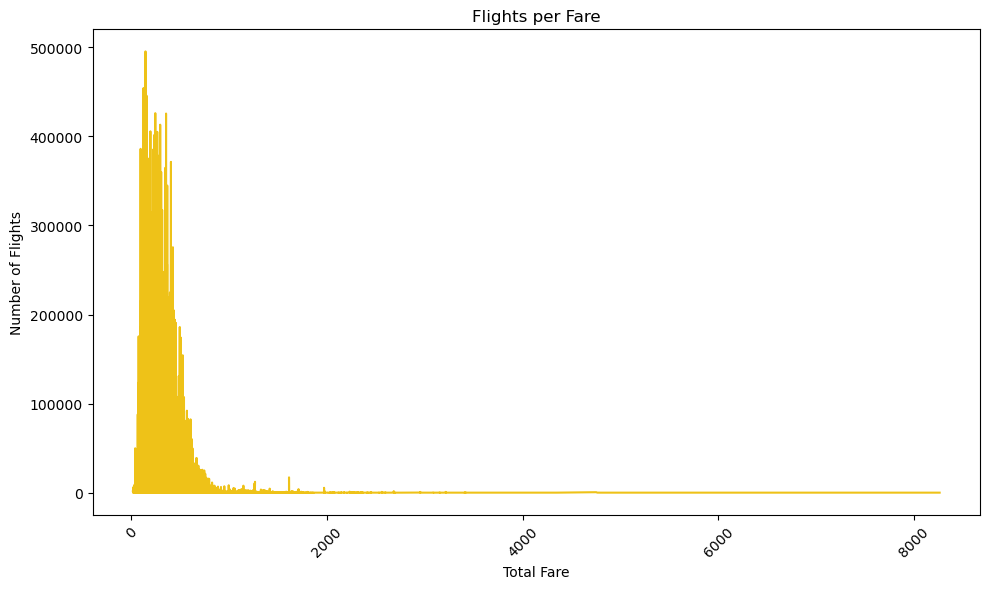

In [35]:
# Group by totalFare and count the number of legIDs
totalFare = df.groupBy("totalFare").agg(F.count("legID").alias("count"))

# Order by totalFare
totalFare = totalFare.orderBy("totalFare")

# Convert to Pandas DataFrame
totalFare_pd = totalFare.toPandas()

# Plotting the distribution of flights per fare
plt.figure(figsize=(10, 6))
plt.plot(totalFare_pd['totalFare'], totalFare_pd['count'], color='#EEC218')  # Set the line color
plt.xlabel('Total Fare')
plt.ylabel('Number of Flights')
plt.title('Flights per Fare')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

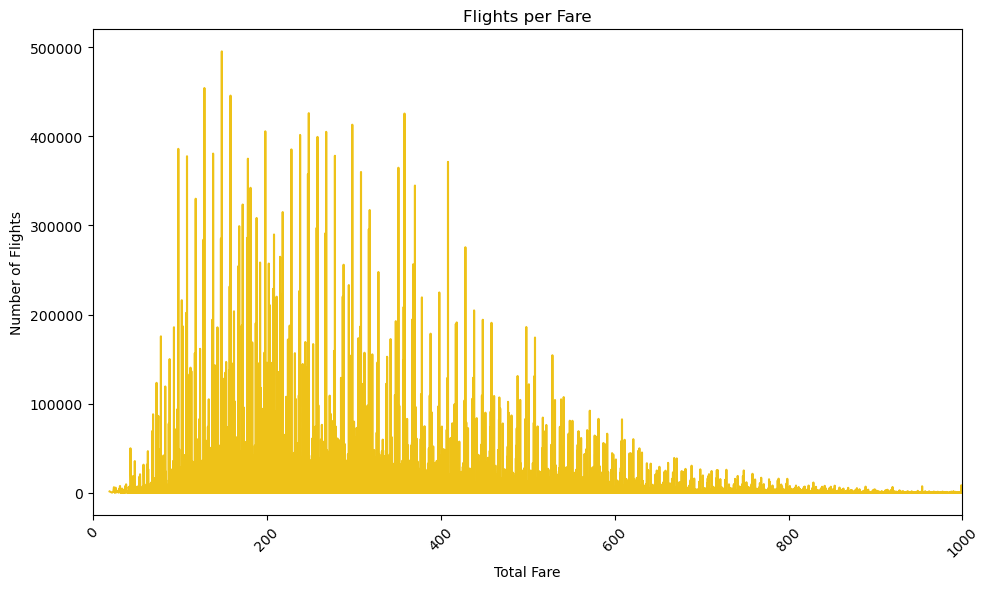

In [37]:
# Zooming in on 0-1000 Fare
plt.figure(figsize=(10, 6))
plt.plot(totalFare_pd['totalFare'], totalFare_pd['count'], color='#EEC218')  # Set the line color
plt.xlabel('Total Fare')
plt.ylabel('Number of Flights')
plt.title('Flights per Fare')
plt.xticks(rotation=45)
plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

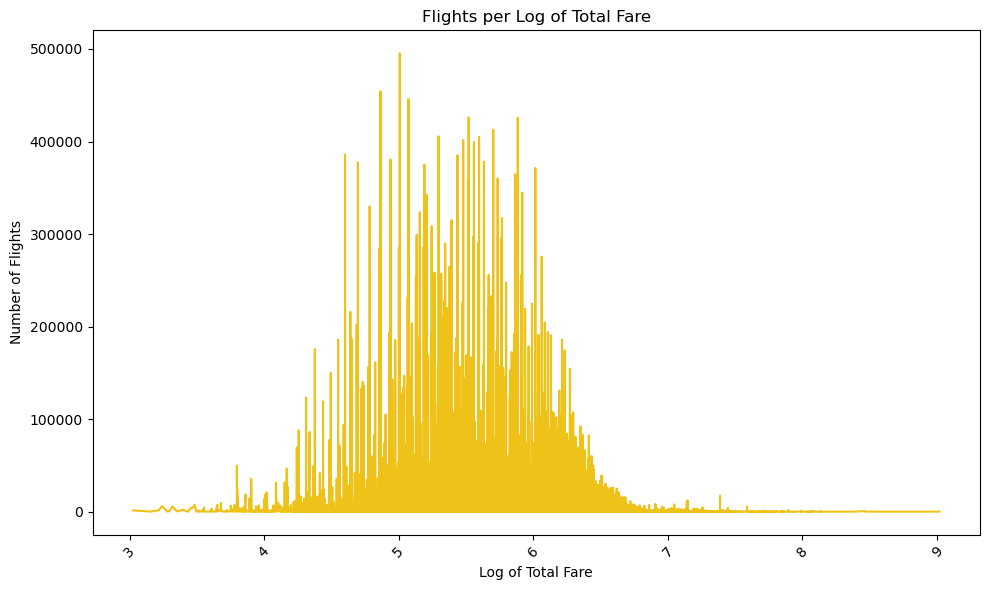

In [3]:
# Calculate log of totalFare
df_log = df.withColumn("log_totalFare", F.log1p("totalFare"))

# Group by log_totalFare and count the number of legIDs
totalFare_log = df_log.groupBy("log_totalFare").agg(F.count("legID").alias("count"))

# Order by log_totalFare
totalFare_log = totalFare_log.orderBy("log_totalFare")

# Convert to Pandas DataFrame
totalFare_log_pd = totalFare_log.toPandas()

# Plotting the distribution of flights per log-transformed fare
plt.figure(figsize=(10, 6))
plt.plot(totalFare_log_pd['log_totalFare'], totalFare_log_pd['count'], color='#EEC218')  # Set the line color
plt.xlabel('Log of Total Fare')
plt.ylabel('Number of Flights')
plt.title('Flights per Log of Total Fare')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Count number of searches per day
searches = df.groupBy("searchDate").agg(F.count("*").alias("count"))

# Order based on date 
searches = searches.orderBy("searchDate")

searches_pd = searches.toPandas()

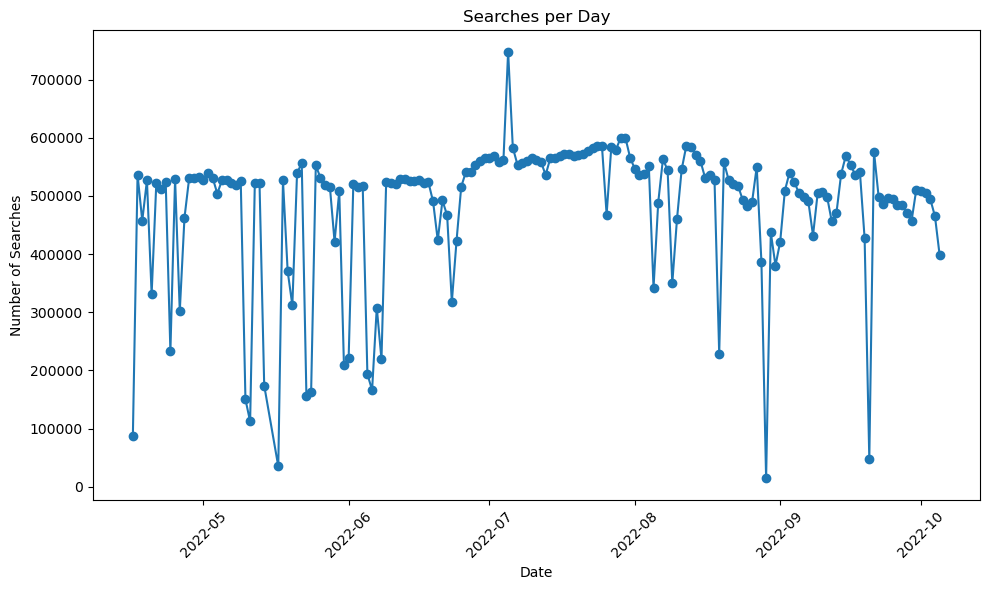

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(searches_pd['searchDate'], searches_pd['count'], marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Searches')
plt.title('Searches per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Remake the time series plot with day of week instead of date 

# Add column to df for day of week
temp_df = df.withColumn('searchDay', F.date_format(F.col('searchDate'), 'EEEE'))

# Count searches per day of week
searches = temp_df.groupBy("searchDay").agg(F.count("*").alias("count"))

searches = searches.orderBy("count")

searches_pd = searches.toPandas()

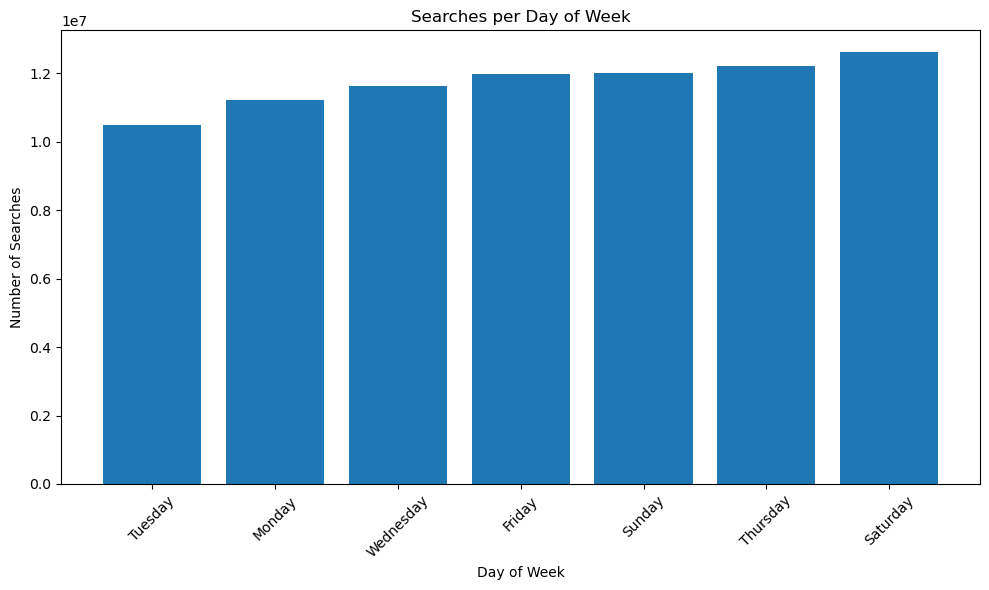

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(searches_pd['searchDay'], searches_pd['count'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Searches')
plt.title('Searches per Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Repeat day of week plotting process for month 
temp_df = df.withColumn('searchDay', F.date_format(F.col('searchDate'), 'MMMM'))

searches = temp_df.groupBy("searchDay").agg(F.count("legID").alias("count"))

searches = searches.orderBy("count")

searches_pd = searches.toPandas()

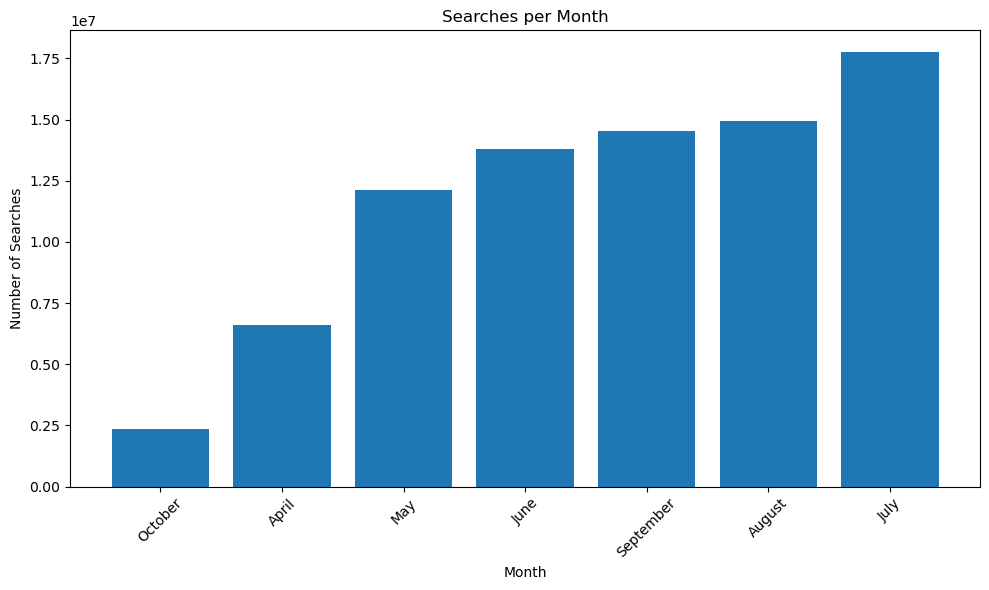

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(searches_pd['searchDay'], searches_pd['count'])
plt.xlabel('Month')
plt.ylabel('Number of Searches')
plt.title('Searches per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Time series of flight dates

# Count unique flights for each date 
flightDates = df.groupBy("flightDate").agg(F.count("legID").alias("count"))

flightDates = flightDates.orderBy("flightDate")

flightDates_pd = flightDates.toPandas()

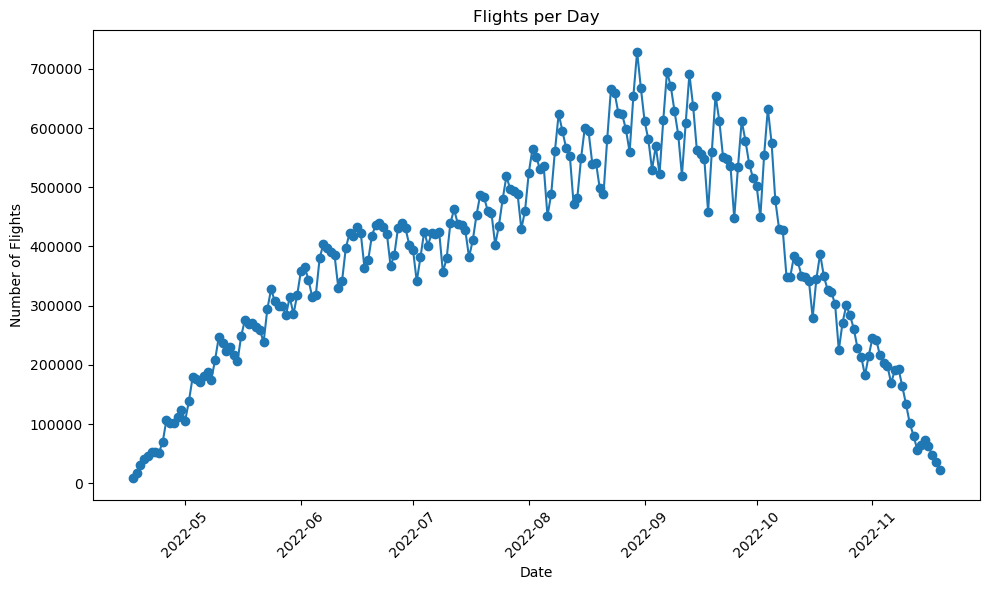

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(flightDates_pd['flightDate'], flightDates_pd['count'], marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.title('Flights per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Plot time series for flight date by day of week (same process as the search date time series)

temp_df = df.withColumn('flightDay', F.date_format(F.col('flightDate'), 'EEEE'))

flightDates = temp_df.groupBy("flightDay").agg(F.count("legID").alias("count"))

flightDates = flightDates.orderBy("count")

flightDates_pd = flightDates.toPandas()

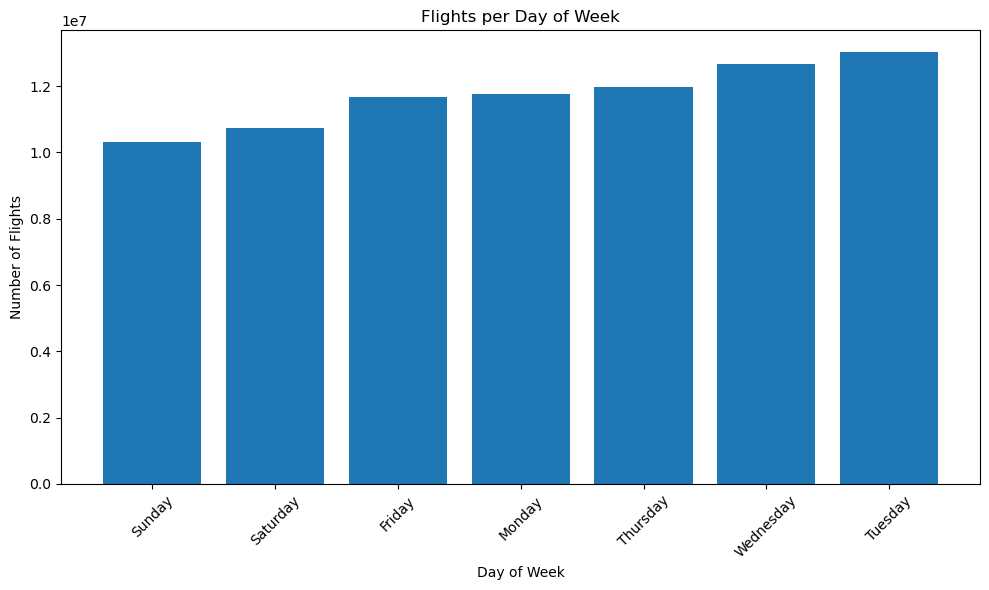

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(flightDates_pd['flightDay'], flightDates_pd['count'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.title('Flights per Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Plot time series for flight date by month (same process as the search date time series)

temp_df = df.withColumn('flightDay', F.date_format(F.col('flightDate'), 'MMMM'))

flightDates = temp_df.groupBy("flightDay").agg(F.count("legID").alias("count"))

flightDates = flightDates.orderBy("count")

flightDates_pd = flightDates.toPandas()

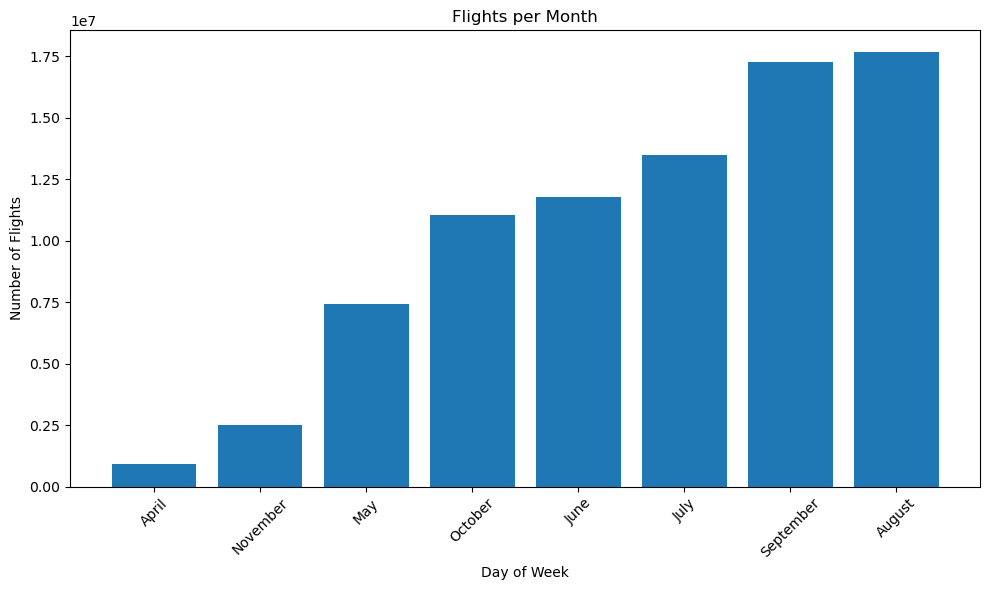

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(flightDates_pd['flightDay'], flightDates_pd['count'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.title('Flights per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Car chart of number of flights per starting airports

# Count unique number of flights for each airport
departures = df.groupBy("startingAirport").agg(F.count("legID").alias("count"))

departures = departures.orderBy("count", ascending=False)

departures_pd = departures.toPandas()

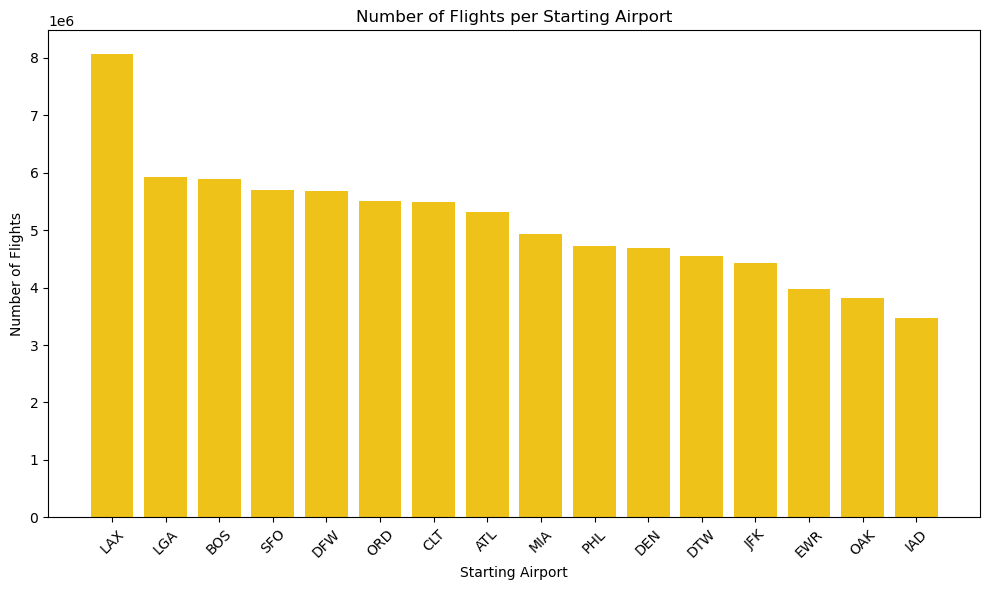

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(departures_pd['startingAirport'], departures_pd['count'], color='#EEC218')
plt.xlabel('Starting Airport')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per Starting Airport')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Bar chart of number of flights per arrival airport

# Count unique number of flights for each airport
destinations = df.groupBy("destinationAirport").agg(F.count("legID").alias("count"))

destinations = destinations.orderBy("count", ascending=False)
destinations_pd = destinations.toPandas()

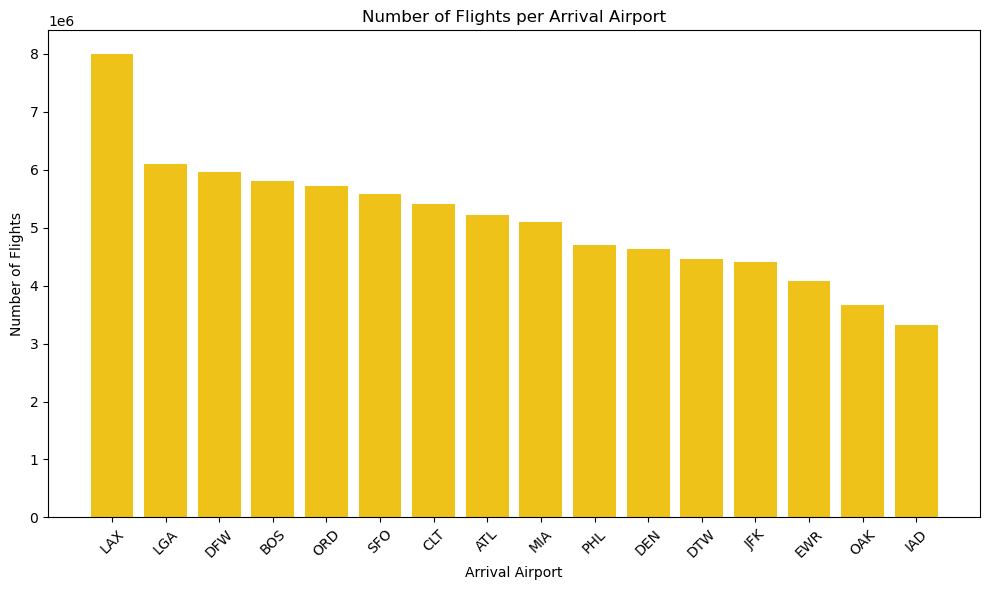

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(destinations_pd['destinationAirport'], destinations_pd['count'], color='#EEC218')
plt.xlabel('Arrival Airport')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per Arrival Airport')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Plot travel duration v.s. number of flights 

# Count how many unique flights there are for each travel duration value 
travelDuration = df.groupBy("travelDuration").agg(F.count("legID").alias("count"))

travelDuration = travelDuration.orderBy("travelDuration")
travelDuration_pd = travelDuration.toPandas()

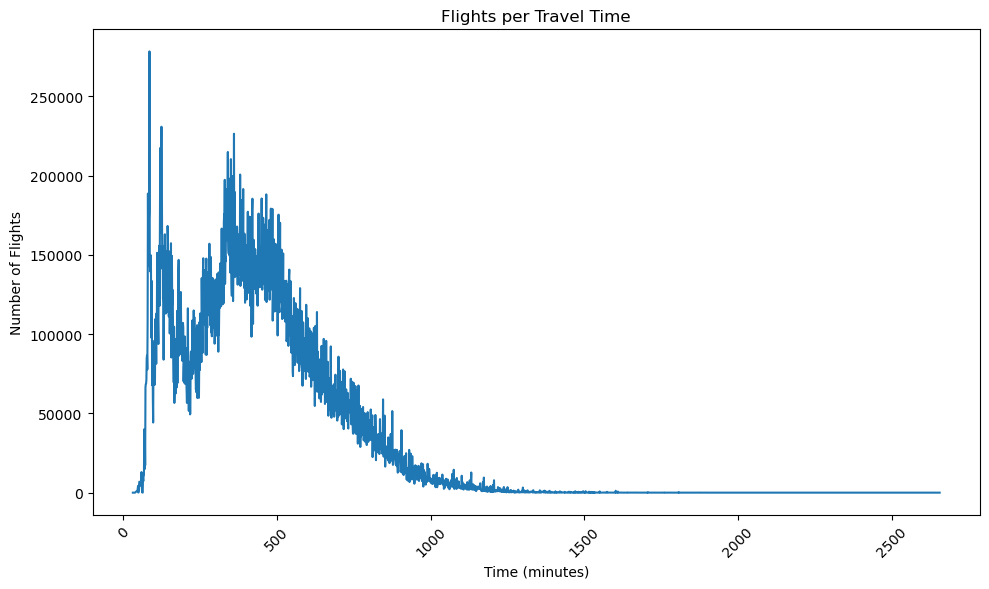

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(travelDuration_pd['travelDuration'], travelDuration_pd['count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Flights')
plt.title('Flights per Travel Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

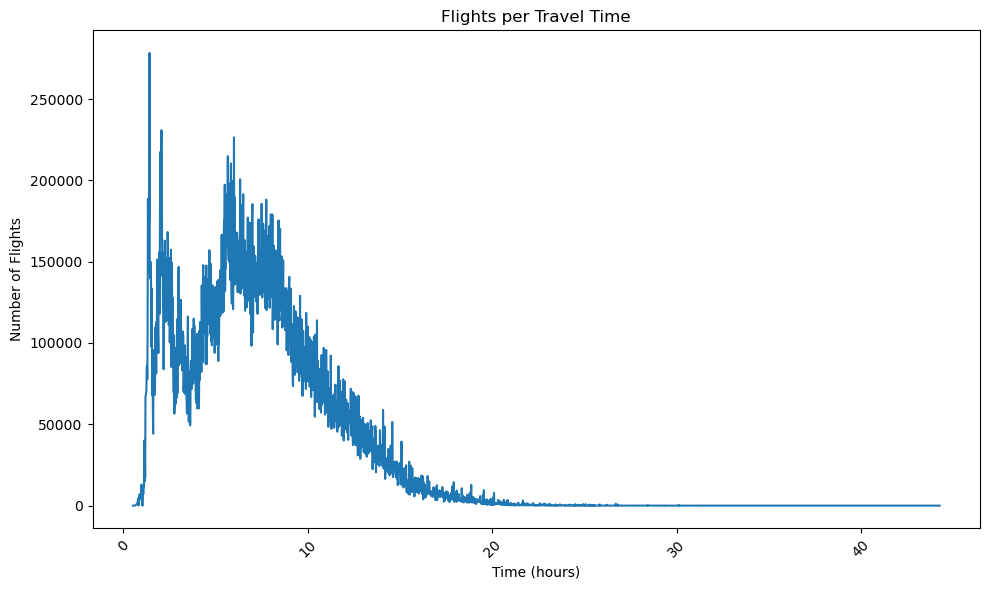

In [24]:
# Redoing above plot but with hours 

plt.figure(figsize=(10, 6))
plt.plot(travelDuration_pd['travelDuration']/60, travelDuration_pd['count'])
plt.xlabel('Time (hours)')
plt.ylabel('Number of Flights')
plt.title('Flights per Travel Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

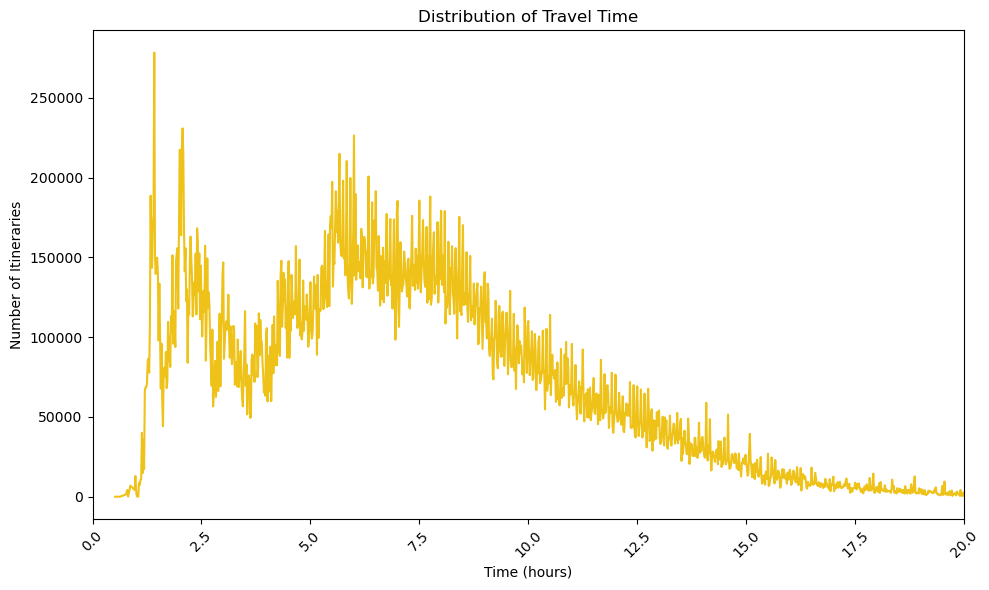

In [25]:
# Redoing above plot but limiting x-axis to 20 hours due to heavy right skew

plt.figure(figsize=(10, 6))
plt.plot(travelDuration_pd['travelDuration']/60, travelDuration_pd['count'], 
         color = '#EEC218')
plt.xlabel('Time (hours)')
plt.ylabel('Number of Itineraries')
plt.title('Distribution of Travel Time')
plt.xticks(rotation=45)
plt.xlim(0, 20)
plt.tight_layout()
plt.show()

In [26]:
# Counting number of unique flights for each elapsed day value
elapsedDays = df.groupBy("elapsedDays").agg(F.count("legID").alias("count"))

elapsedDays = elapsedDays.orderBy("elapsedDays")
elapsedDays_pd = elapsedDays.toPandas()

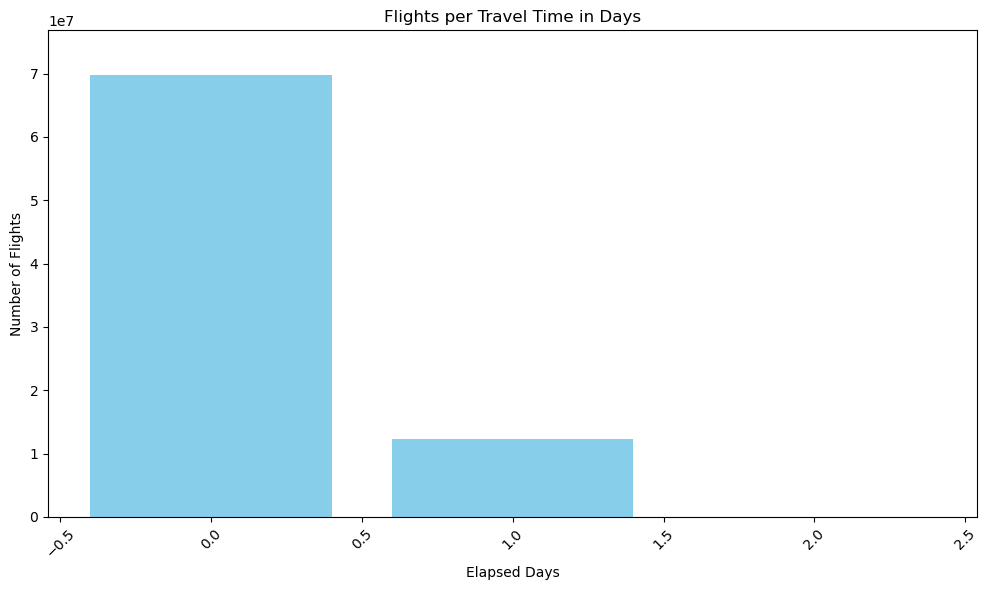

In [27]:
plt.figure(figsize=(10, 6))
plt.bar(elapsedDays_pd['elapsedDays'], elapsedDays_pd['count'], color='skyblue')
plt.xlabel('Elapsed Days')
plt.ylabel('Number of Flights')
plt.title('Flights per Travel Time in Days')
plt.ylim(0, max(elapsedDays_pd['count']) * 1.1) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Bar chart visualization not that good so just look at the dataframe
elapsedDays_pd.head()

,elapsedDays,count
0,0,69847188
1,1,12290812
2,2,753


In [29]:
# Counting number of unique flights for refundability value 
isRefundable = df.groupBy("isRefundable").agg(F.count("legID").alias("count"))

isRefundable = isRefundable.orderBy("isRefundable")

isRefundable_pd = isRefundable.toPandas()

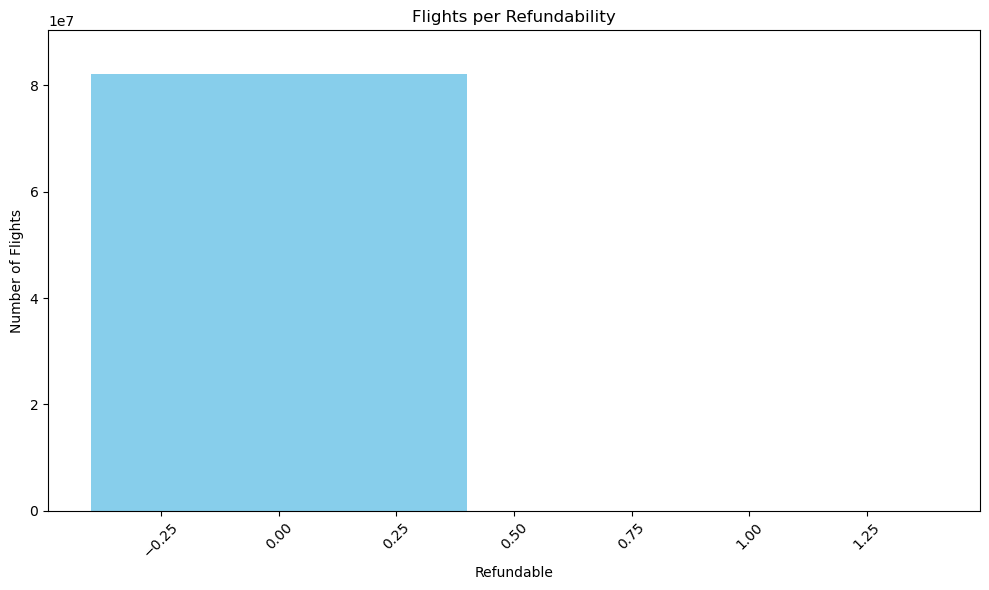

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(isRefundable_pd['isRefundable'], isRefundable_pd['count'], color='skyblue')
plt.xlabel('Refundable')
plt.ylabel('Number of Flights')
plt.title('Flights per Refundability')
plt.ylim(0, max(isRefundable_pd['count']) * 1.1) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Bar chart again not good for visualization so look at dataframe
isRefundable_pd.head()

,isRefundable,count
0,0,82137421
1,1,1332


In [32]:
# Counting number of unique flights for nonstop value
isNonstop = df.groupBy("isNonstop").agg(F.count("legID").alias("count"))

isNonstop = isNonstop.orderBy("isNonstop")

isNonstop_pd = isNonstop.toPandas()

In [33]:
isNonstop_pd.head()

,isNonstop,count
0,0,60071865
1,1,22066888


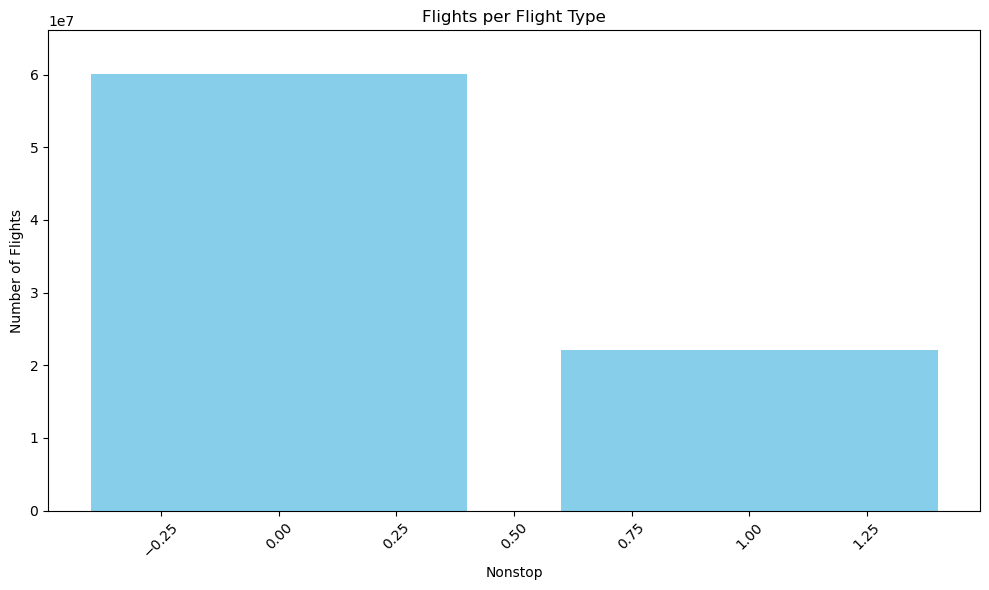

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(isNonstop_pd['isNonstop'], isNonstop_pd['count'], color='skyblue')
plt.xlabel('Nonstop')
plt.ylabel('Number of Flights')
plt.title('Flights per Flight Type')
plt.ylim(0, max(isNonstop_pd['count']) * 1.1) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Count number of flights per each amount of remaning seats 
seatsRemaining = df.groupBy("seatsRemaining").agg(F.count("legID").alias("count"))

seatsRemaining = seatsRemaining.orderBy("seatsRemaining")

seatsRemaining_pd = seatsRemaining.toPandas()

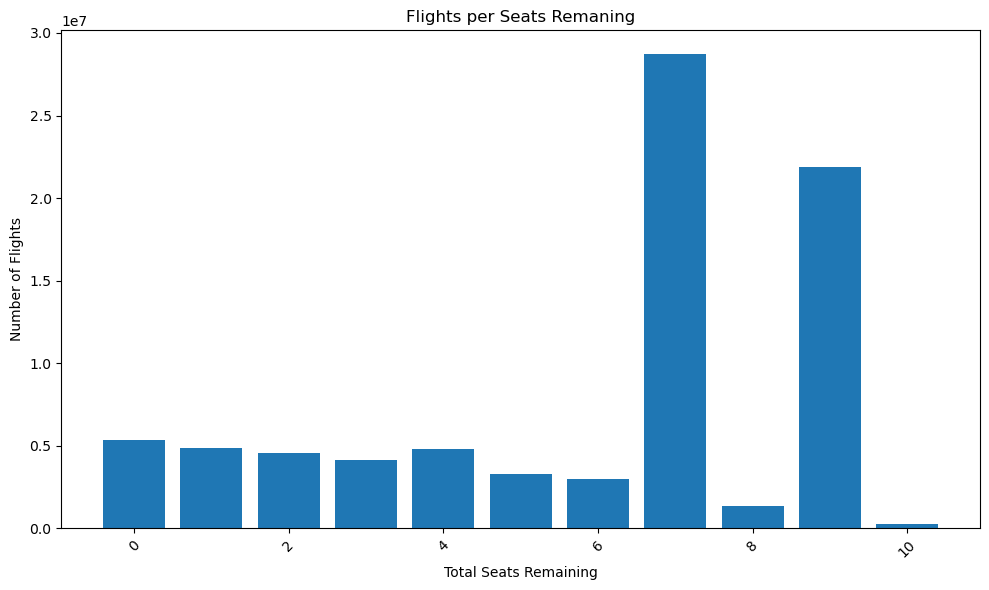

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(seatsRemaining_pd['seatsRemaining'], seatsRemaining_pd['count'])
plt.xlabel('Total Seats Remaining')
plt.ylabel('Number of Flights')
plt.title('Flights per Seats Remaning')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Counting number of flights for each day before flight value 
DaysBeforeFlight = df.groupBy("DaysBeforeFlight").agg(F.count("legID").alias("count"))

DaysBeforeFlight = DaysBeforeFlight.orderBy("DaysBeforeFlight")

DaysBeforeFlight_pd = DaysBeforeFlight.toPandas()

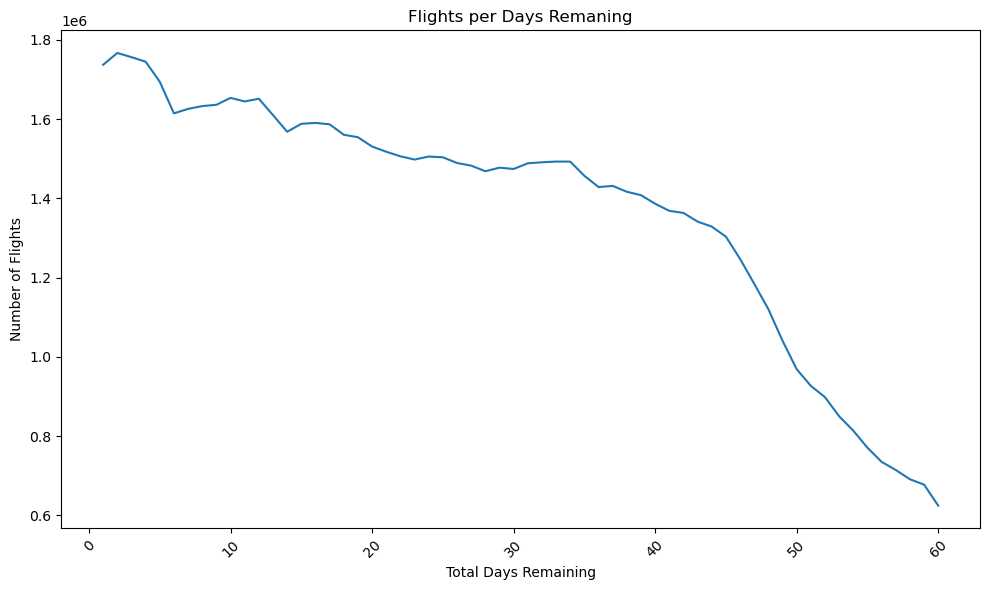

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(DaysBeforeFlight_pd['DaysBeforeFlight'], DaysBeforeFlight_pd['count'])
plt.xlabel('Total Days Remaining')
plt.ylabel('Number of Flights')
plt.title('Flights per Days Remaning')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Number of flights per number of stops
numStops = df.groupBy("numStops").agg(F.count("legID").alias("count"))

numStops = numStops.orderBy("numStops")

numStops_pd = numStops.toPandas()

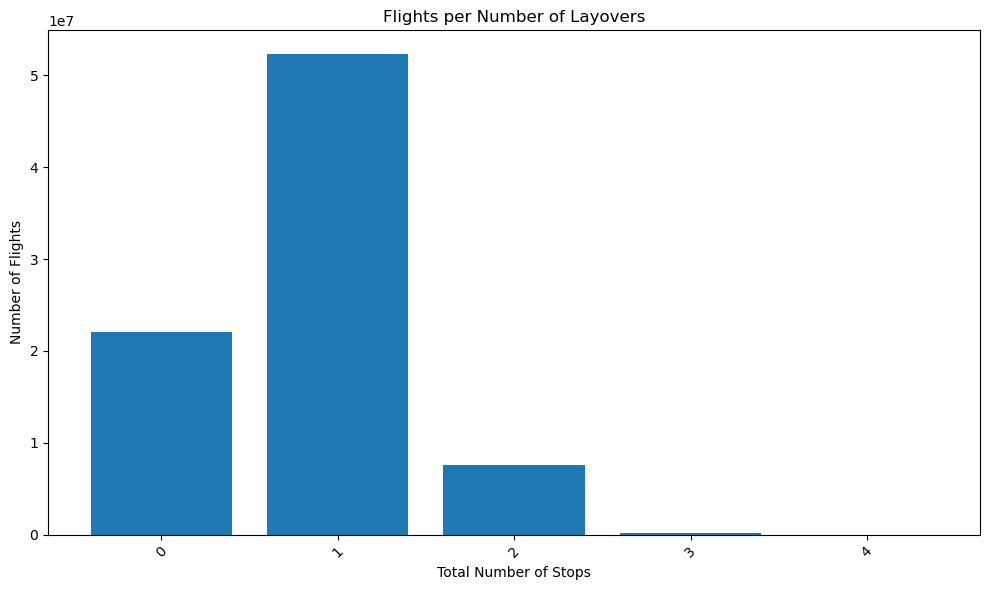

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(numStops_pd['numStops'], numStops_pd['count'])
plt.xlabel('Total Number of Stops')
plt.ylabel('Number of Flights')
plt.title('Flights per Number of Layovers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# Looking at dataframe since bar chart isn't a good visualization
numStops_pd.head()

,numStops,count
0,0,22066888
1,1,52285467
2,2,7586488
3,3,199812
4,4,98


In [45]:
# Counting number of trips with different numbers of unique airlines 
numUniqueAirlines = df.groupBy("numUniqueAirlines").agg(F.count("*").alias("count"))

numUniqueAirlines = numUniqueAirlines.orderBy("numUniqueAirlines")

numUniqueAirlines_pd = numUniqueAirlines.toPandas()

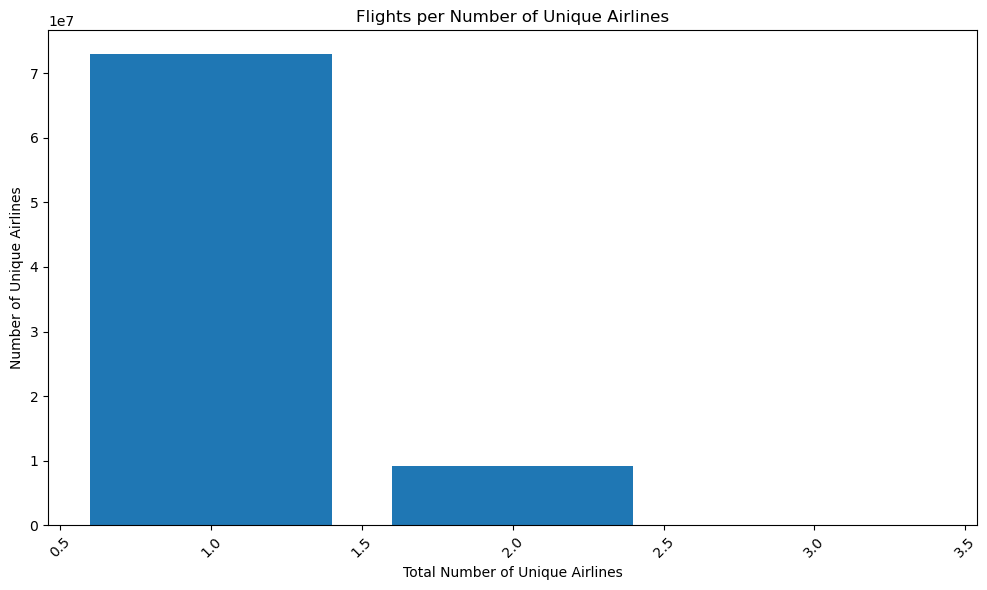

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(numUniqueAirlines_pd['numUniqueAirlines'], numUniqueAirlines_pd['count'])
plt.xlabel('Total Number of Unique Airlines')
plt.ylabel('Number of Unique Airlines')
plt.title('Flights per Number of Unique Airlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
# Look at dataframe since bar chart doesn't visualize well
numUniqueAirlines_pd.head()

,numUniqueAirlines,count
0,1,73002356
1,2,9110765
2,3,25632


In [48]:
# Drop duplicates 
temp_df = df.dropDuplicates(["legID"])

In [49]:
# Finding average flight price for each starting airport 
avg_flight_price = temp_df.groupBy("startingAirport").agg(F.avg("totalFare").alias("avg_flightPrice"))

avg_flight_price_pd = avg_flight_price.toPandas()

avg_flight_price.show(avg_flight_price.count())

+---------------+------------------+
|startingAirport|   avg_flightPrice|
+---------------+------------------+
|            OAK| 620.1515000371328|
|            LGA|  405.452520345075|
|            BOS|357.77652814938267|
|            EWR|387.37340999159875|
|            DEN|386.95331682592433|
|            IAD| 441.4063581208061|
|            CLT|388.24753347321433|
|            MIA|367.08565153839413|
|            DFW| 346.4128345028369|
|            SFO| 509.4540223607923|
|            ATL|377.30425280034524|
|            ORD| 333.3764628947472|
|            DTW| 409.1490061195265|
|            LAX| 434.0287356028442|
|            JFK| 436.6152050477875|
|            PHL|408.33239528704394|
+---------------+------------------+



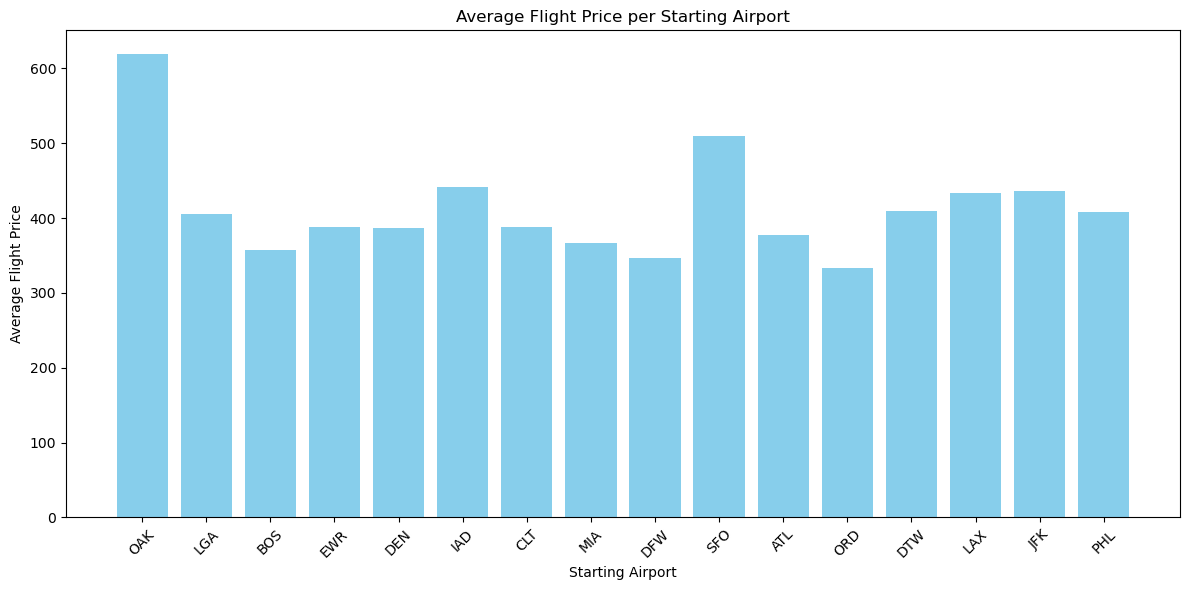

In [53]:
plt.figure(figsize=(12, 6))
plt.bar(avg_flight_price_pd['startingAirport'], avg_flight_price_pd['avg_flightPrice'], color='skyblue')
plt.xlabel('Starting Airport')
plt.ylabel('Average Flight Price')
plt.title('Average Flight Price per Starting Airport')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [54]:
# Finding average flight price for each destination airport 
avg_flight_price = temp_df.groupBy("destinationAirport").agg(F.avg("totalFare").alias("avg_flightPrice"))

avg_flight_price_pd = avg_flight_price.toPandas()

avg_flight_price.show(avg_flight_price.count())

+------------------+------------------+
|destinationAirport|   avg_flightPrice|
+------------------+------------------+
|               OAK| 627.7600351775646|
|               LGA| 403.6998713621968|
|               BOS| 369.3250828151387|
|               EWR| 399.6668909852515|
|               DEN|393.83222037013684|
|               IAD|436.19078159441995|
|               CLT|391.62885634921884|
|               MIA| 360.4948983609383|
|               DFW| 349.2189696727149|
|               SFO| 502.0921814804315|
|               ATL|375.48269117605696|
|               ORD| 344.9272175283525|
|               DTW| 414.4726314276653|
|               LAX|412.68614846130896|
|               JFK| 429.5829758403273|
|               PHL|424.32387888218415|
+------------------+------------------+



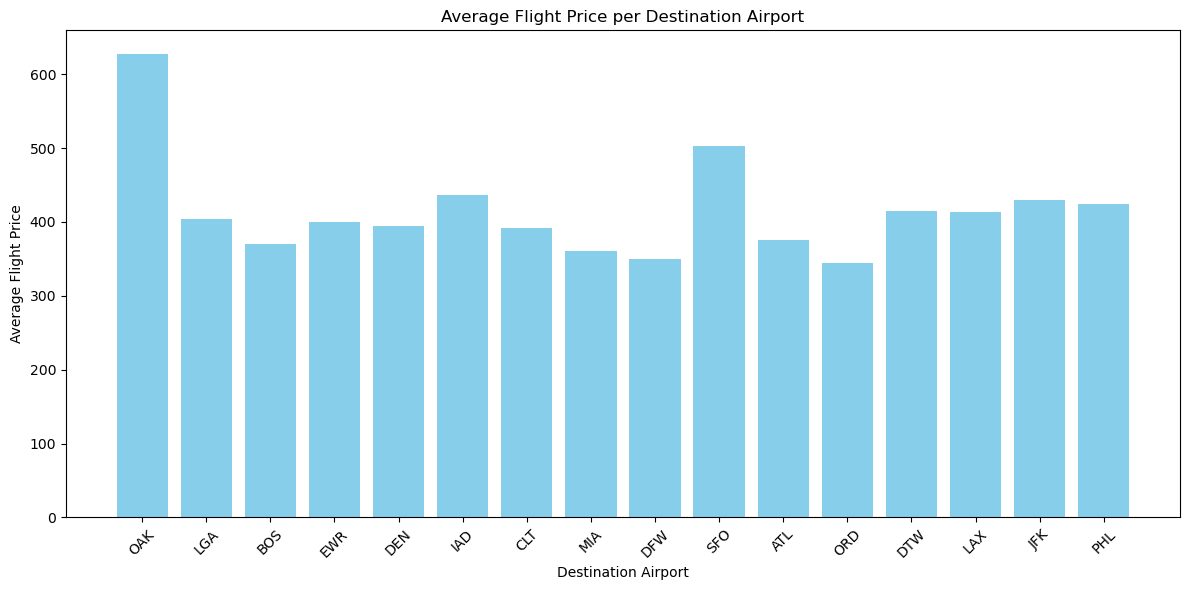

In [55]:
plt.figure(figsize=(12, 6))
plt.bar(avg_flight_price_pd['destinationAirport'], avg_flight_price_pd['avg_flightPrice'], color='skyblue')
plt.xlabel('Destination Airport')
plt.ylabel('Average Flight Price')
plt.title('Average Flight Price per Destination Airport')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [56]:
# Add column for month 
temp_df = temp_df.withColumn('month', F.date_format('flightDate', 'MMMM'))

In [69]:
# Find average flight price by month
avg_flight_price = temp_df.groupBy("month").agg(F.avg("totalFare").alias("avg_flightPrice"))

avg_flight_price_pd = avg_flight_price.toPandas()

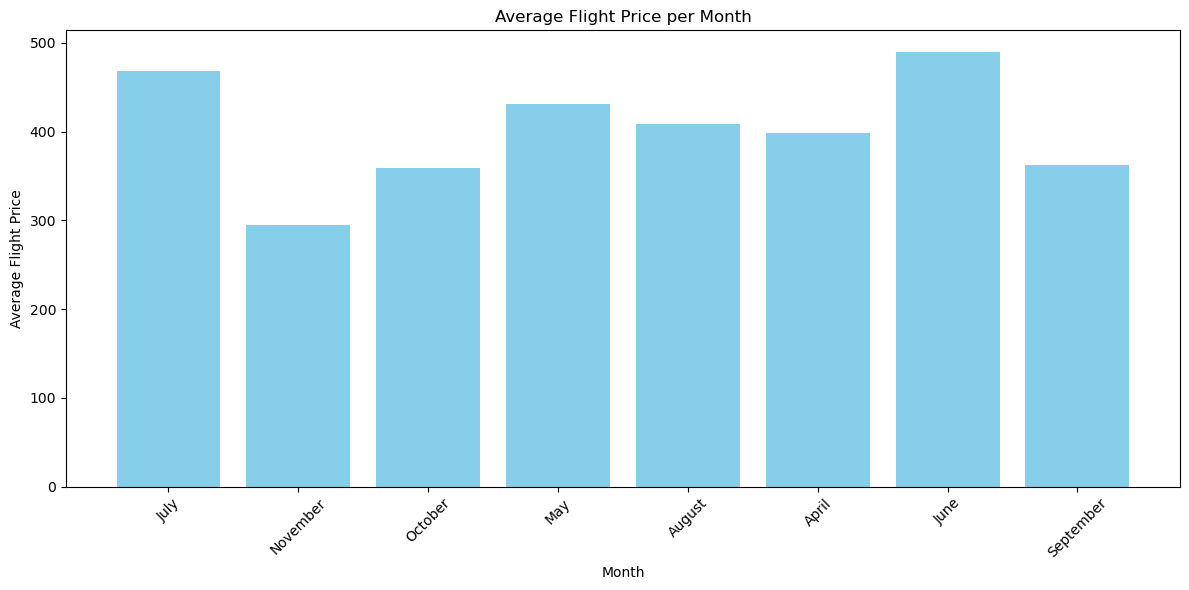

In [63]:
plt.figure(figsize=(12, 6))
plt.bar(avg_flight_price_pd['month'], avg_flight_price_pd['avg_flightPrice'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Flight Price')
plt.title('Average Flight Price per Month')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [64]:
# Counting number of flights between each starting and destination airport combination for a heat map
flight_counts = temp_df.groupBy("startingAirport", "destinationAirport").agg(F.count("legID").alias("flightCount"))

In [65]:
# Pivot df to be used in heatmap
pivot_df = flight_counts.groupBy("startingAirport").pivot("destinationAirport").agg(F.first("flightCount"))

pivot_pd = pivot_df.toPandas()

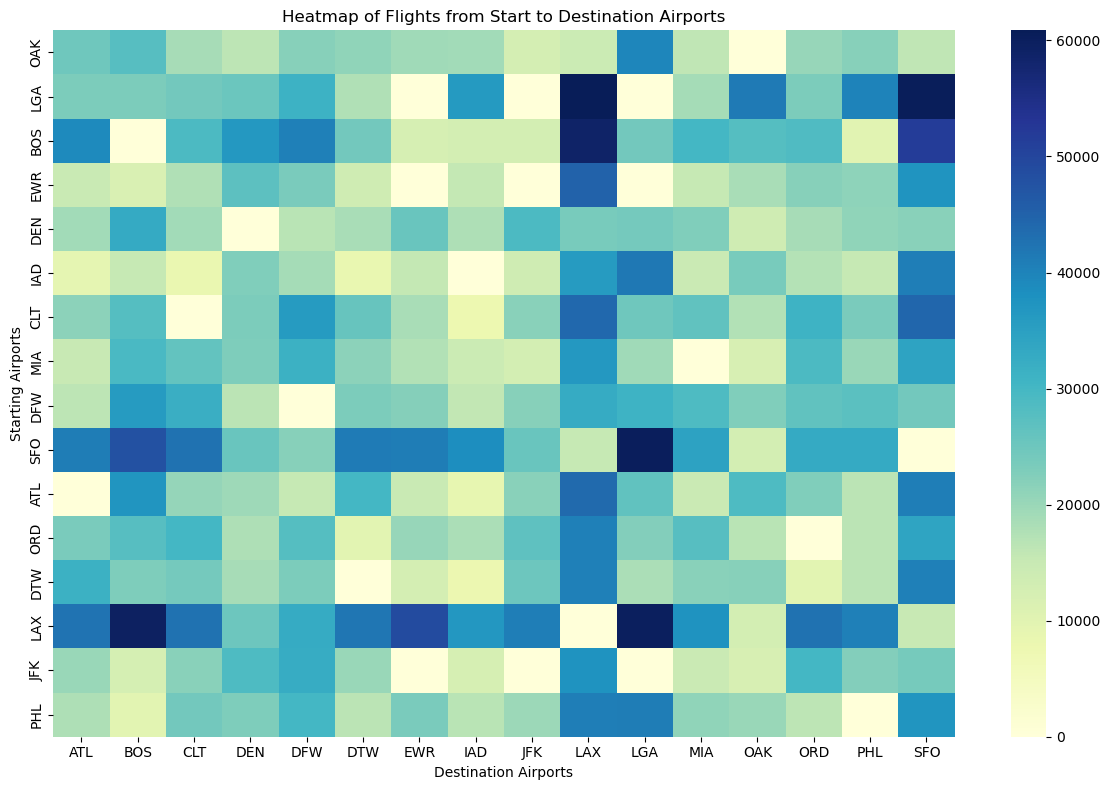

In [66]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_pd.set_index('startingAirport').fillna(0), cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Flights from Start to Destination Airports')
plt.xlabel('Destination Airports')
plt.ylabel('Starting Airports')
plt.tight_layout()
plt.show()

In [67]:
# Count number of unique itineraries for travel distance 
distance = df.groupBy("totalTravelDistance").agg(F.count("legID").alias("count"))

distance = distance.orderBy("totalTravelDistance")

distance_pd = distance.toPandas()

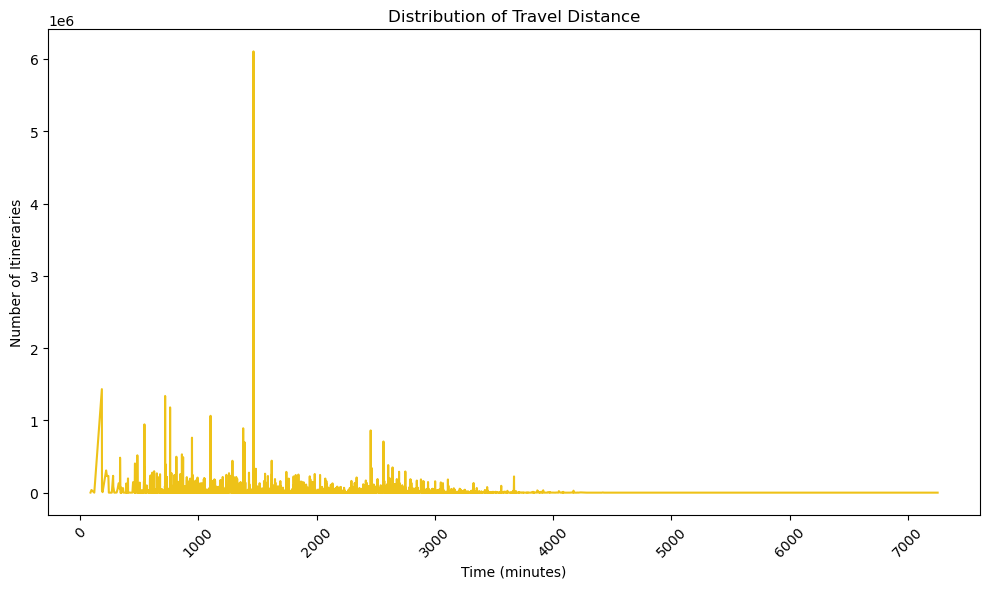

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(distance_pd['totalTravelDistance'], distance_pd['count'], color = '#EEC218')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Itineraries')
plt.title('Distribution of Travel Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

+--------+------------------+
|NumStops|   averageDuration|
+--------+------------------+
|       1| 480.9272656969861|
|       3|  694.464671791484|
|       4|1530.7142857142858|
|       2| 777.7794564494137|
|       0|181.13981790273283|
+--------+------------------+



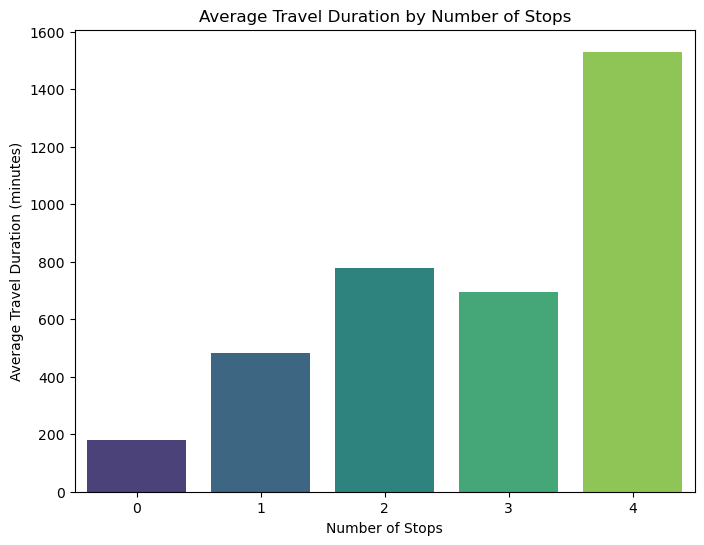

In [78]:
# Calculate average travel duration by number of stops
df_duration_stops = df.groupBy('NumStops').avg('travelDuration').withColumnRenamed('avg(travelDuration)', 'averageDuration')
df_duration_stops.show()

# Convert to Pandas for visualization if needed
df_duration_stops_pandas = df_duration_stops.toPandas()

# Plot the average travel duration by number of stops
plt.figure(figsize=(8, 6))
sns.barplot(data=df_duration_stops_pandas, x='NumStops', y='averageDuration', palette='viridis')
plt.title("Average Travel Duration by Number of Stops")
plt.xlabel("Number of Stops")
plt.ylabel("Average Travel Duration (minutes)")
plt.show()

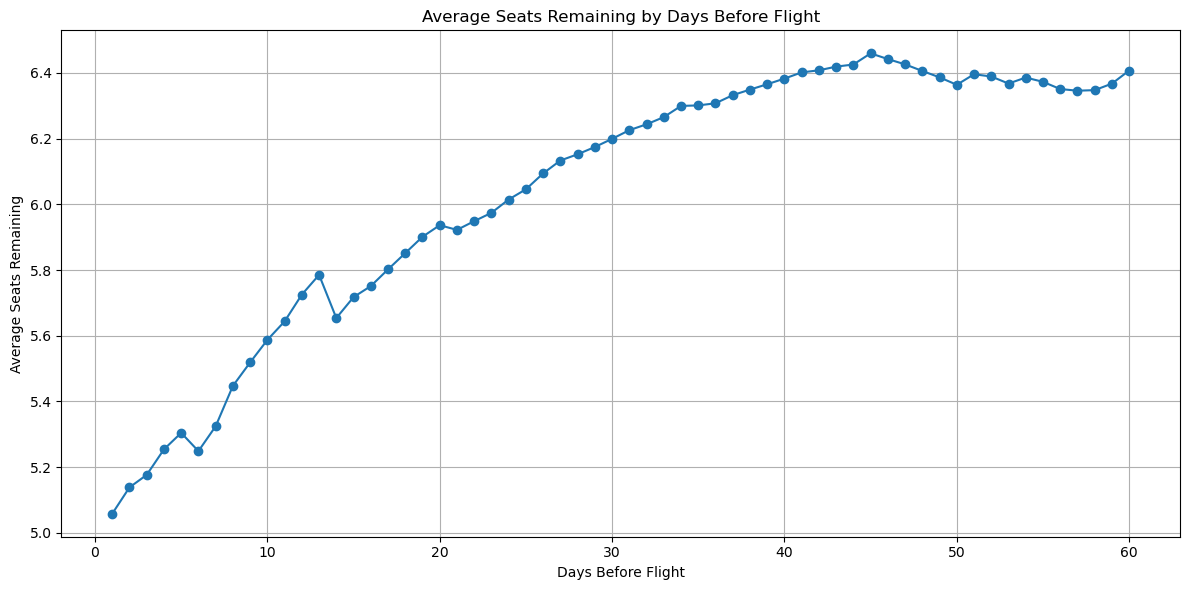

In [79]:
# Group by DaysBeforeFlight and calculate average seatsRemaining
df_days_before_flight = (
    df.groupBy('DaysBeforeFlight')
    .avg('seatsRemaining')
    .withColumnRenamed('avg(seatsRemaining)', 'averageSeatsRemaining')
)

# Sort by DaysBeforeFlight in ascending order
df_days_before_flight = df_days_before_flight.orderBy('DaysBeforeFlight')

# Convert to Pandas for visualization
df_days_before_flight_pandas = df_days_before_flight.toPandas()

# Plot the relationship between DaysBeforeFlight and seatsRemaining
plt.figure(figsize=(12, 6))
plt.plot(
    df_days_before_flight_pandas['DaysBeforeFlight'],
    df_days_before_flight_pandas['averageSeatsRemaining'],
    marker='o',
    linestyle='-'
)
plt.title("Average Seats Remaining by Days Before Flight")
plt.xlabel("Days Before Flight")
plt.ylabel("Average Seats Remaining")
plt.grid(True)  # Optional: Adds grid for better readability
plt.tight_layout()
plt.show()